# 03 — Deep Evaluation

Beyond accuracy — ROC curves, confidence analysis, per-class metrics, and error analysis.

---

In [1]:
import sys
sys.path.append('..')

import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from PIL import Image

from src.config import (
    DATA_DIR, MODELS_DIR, RESULTS_DIR, SEED,
    CLASS_NAMES, CLASS_LABELS, NUM_CLASSES,
    IMAGE_SIZE, BATCH_SIZE, MODEL_NAME,
)

sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 120

device = torch.device('cpu')
print(f'Device: {device}')
print('Setup complete!')

Device: cpu
Setup complete!


---
## 1. Load Model & Test Data

Same seed = same split as training. We evaluate on the exact same test images.

In [2]:
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from src.dataset import HAM10000Dataset, get_transforms
from src.model import create_model

# Load metadata and recreate the same splits
df = pd.read_csv(DATA_DIR / 'HAM10000_metadata.csv')
image_dirs = [
    DATA_DIR / 'HAM10000_images_part_1',
    DATA_DIR / 'HAM10000_images_part_2',
]

# Same split as training (same seed = same split)
train_val_df, test_df = train_test_split(df, test_size=0.15, stratify=df['dx'], random_state=SEED)
train_df, val_df = train_test_split(train_val_df, test_size=0.176, stratify=train_val_df['dx'], random_state=SEED)

# Create test dataset and loader
test_dataset = HAM10000Dataset(test_df, image_dirs=image_dirs, transform=get_transforms('test'))
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

# Load the best model
model = create_model(MODEL_NAME, NUM_CLASSES, pretrained=False)
model.load_state_dict(torch.load(MODELS_DIR / 'best_model.pth', map_location=device, weights_only=True))
model = model.to(device)
model.eval()

print(f'Test samples: {len(test_df)}')
print(f'Model loaded from: {MODELS_DIR / "best_model.pth"}')

Test samples: 1503
Model loaded from: D:\Projects\Vision_something\models\best_model.pth


In [3]:
from src.evaluate import get_predictions

# Get all predictions on test set
y_true, y_pred, y_probs = get_predictions(model, test_loader, device)

accuracy = (y_true == y_pred).mean()
print(f'Test accuracy: {accuracy:.4f} ({accuracy*100:.1f}%)')
print(f'Total predictions: {len(y_true)}')

Predicting: 100%|██████████| 94/94 [02:14<00:00,  1.43s/it]

Test accuracy: 0.7585 (75.8%)
Total predictions: 1503


---
## 2. ROC Curves (One-vs-Rest)

For each class: how well can the model separate it from all others?

- **AUC = 1.0** — perfect | **AUC = 0.5** — random guessing | **AUC > 0.9** — excellent

Saved to D:\Projects\Vision_something\results\roc_curves.png


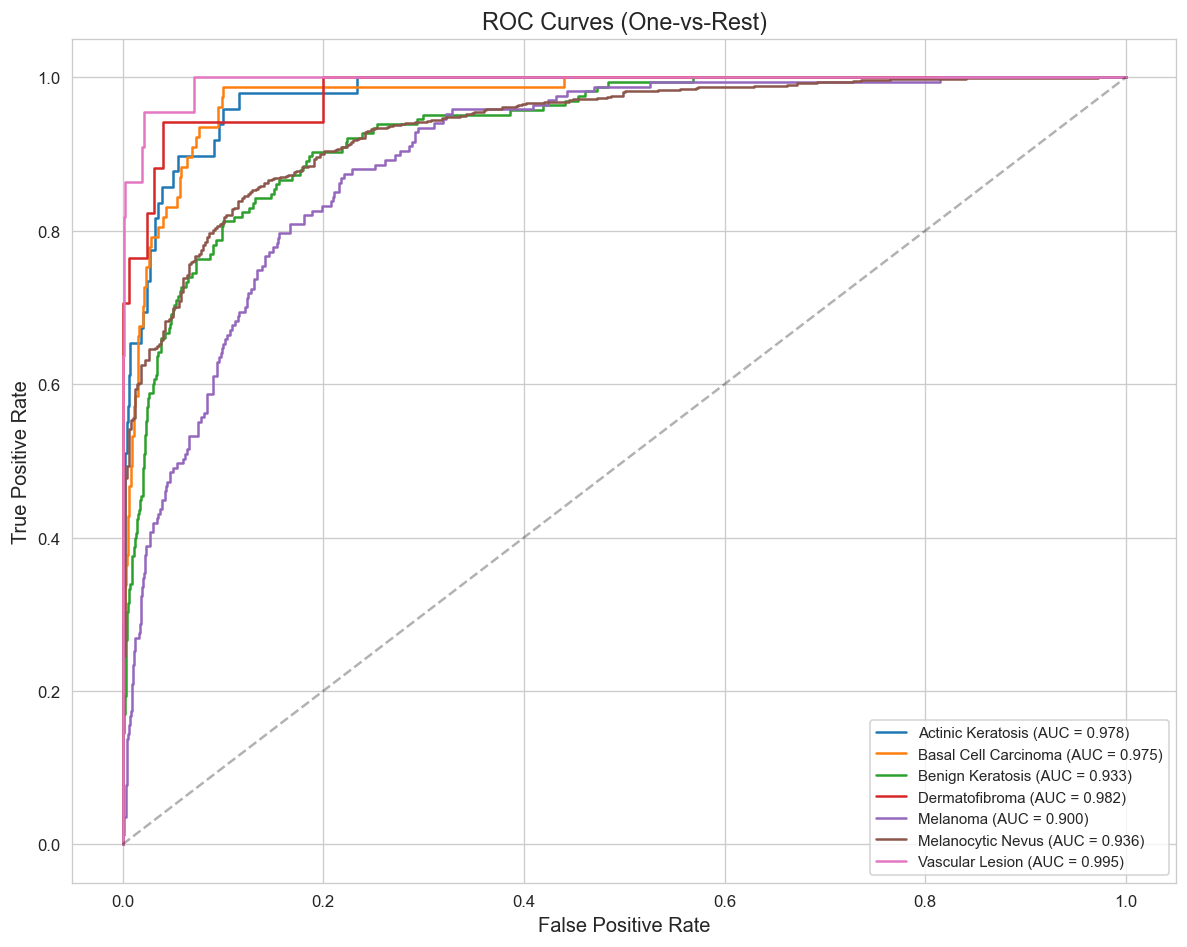

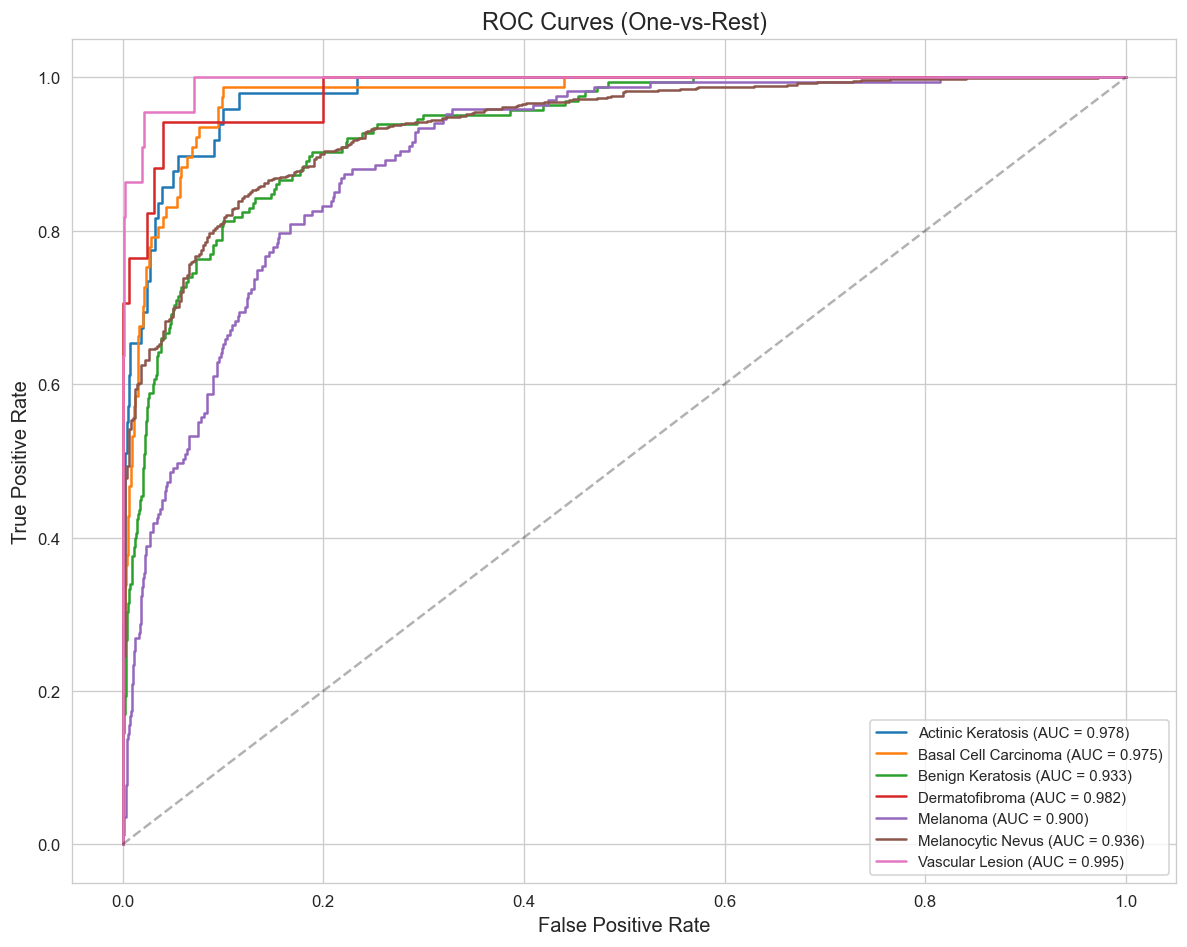

In [4]:
from src.evaluate import plot_roc_curves

plot_roc_curves(y_true, y_probs, save=True)

In [5]:
# Print AUC scores in a clean table
from sklearn.metrics import roc_auc_score

print('AUC Scores per class:')
print('-' * 50)
aucs = []
for i, cls in enumerate(CLASS_NAMES):
    binary_true = (y_true == i).astype(int)
    auc_score = roc_auc_score(binary_true, y_probs[:, i])
    aucs.append(auc_score)
    label = CLASS_LABELS[cls]
    bar = '█' * int(auc_score * 30)
    print(f'  {label:30s}  AUC: {auc_score:.3f}  {bar}')

print('-' * 50)
print(f'  {"Mean AUC":30s}  AUC: {np.mean(aucs):.3f}')

AUC Scores per class:
--------------------------------------------------
  Actinic Keratosis               AUC: 0.978  █████████████████████████████
  Basal Cell Carcinoma            AUC: 0.975  █████████████████████████████
  Benign Keratosis                AUC: 0.933  ███████████████████████████
  Dermatofibroma                  AUC: 0.982  █████████████████████████████
  Melanoma                        AUC: 0.900  ██████████████████████████
  Melanocytic Nevus               AUC: 0.936  ████████████████████████████
  Vascular Lesion                 AUC: 0.995  █████████████████████████████
--------------------------------------------------
  Mean AUC                        AUC: 0.957


### ROC Results

All classes have **AUC > 0.9** — the model separates every class well. Mean AUC of 0.957 is excellent. ROC is more reliable than accuracy for imbalanced data because it evaluates across all decision thresholds.

---
## 3. Confidence Analysis

Is the model more confident when it's right than when it's wrong? A good model should "know what it doesn't know."

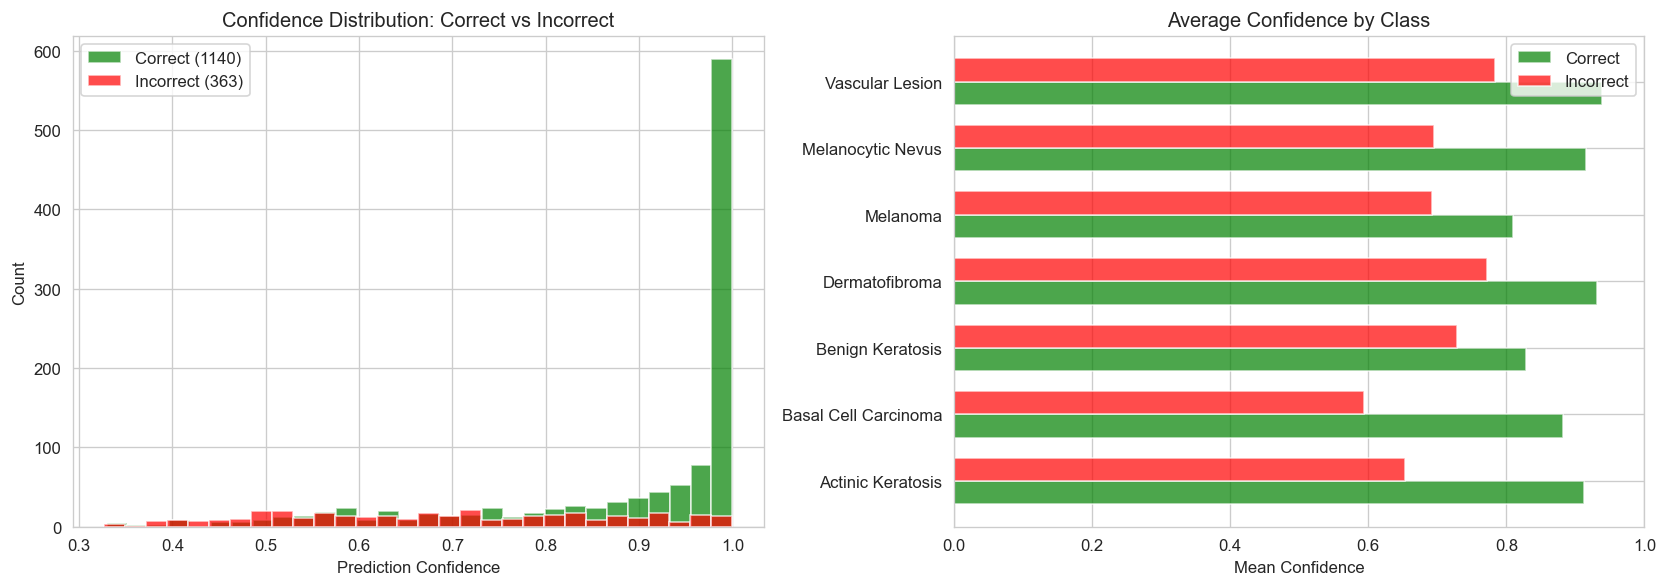


Mean confidence (correct):   0.894
Mean confidence (incorrect): 0.692


In [6]:
# Get the confidence (max probability) for each prediction
confidences = y_probs.max(axis=1)
correct_mask = y_true == y_pred

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Distribution of confidence for correct vs incorrect
axes[0].hist(confidences[correct_mask], bins=30, alpha=0.7, label=f'Correct ({correct_mask.sum()})', color='green')
axes[0].hist(confidences[~correct_mask], bins=30, alpha=0.7, label=f'Incorrect ({(~correct_mask).sum()})', color='red')
axes[0].set_xlabel('Prediction Confidence')
axes[0].set_ylabel('Count')
axes[0].set_title('Confidence Distribution: Correct vs Incorrect')
axes[0].legend()

# Average confidence per class
class_conf_correct = []
class_conf_incorrect = []
for i, cls in enumerate(CLASS_NAMES):
    mask = y_true == i
    correct = mask & correct_mask
    incorrect = mask & ~correct_mask
    class_conf_correct.append(confidences[correct].mean() if correct.sum() > 0 else 0)
    class_conf_incorrect.append(confidences[incorrect].mean() if incorrect.sum() > 0 else 0)

x = np.arange(len(CLASS_NAMES))
width = 0.35
labels = [CLASS_LABELS[c] for c in CLASS_NAMES]
axes[1].barh(x - width/2, class_conf_correct, width, label='Correct', color='green', alpha=0.7)
axes[1].barh(x + width/2, class_conf_incorrect, width, label='Incorrect', color='red', alpha=0.7)
axes[1].set_yticks(x)
axes[1].set_yticklabels(labels)
axes[1].set_xlabel('Mean Confidence')
axes[1].set_title('Average Confidence by Class')
axes[1].legend()
axes[1].set_xlim(0, 1)

plt.tight_layout()
fig.savefig(RESULTS_DIR / 'confidence_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

print(f'\nMean confidence (correct):   {confidences[correct_mask].mean():.3f}')
print(f'Mean confidence (incorrect): {confidences[~correct_mask].mean():.3f}')

### Confidence Results

Higher confidence on correct predictions = the model is well-calibrated. High-confidence wrong predictions are the most dangerous cases — especially in medical AI where a confident wrong answer could delay treatment.

---
## 4. Per-Class Metrics

Precision, recall, and F1 side by side for each class.

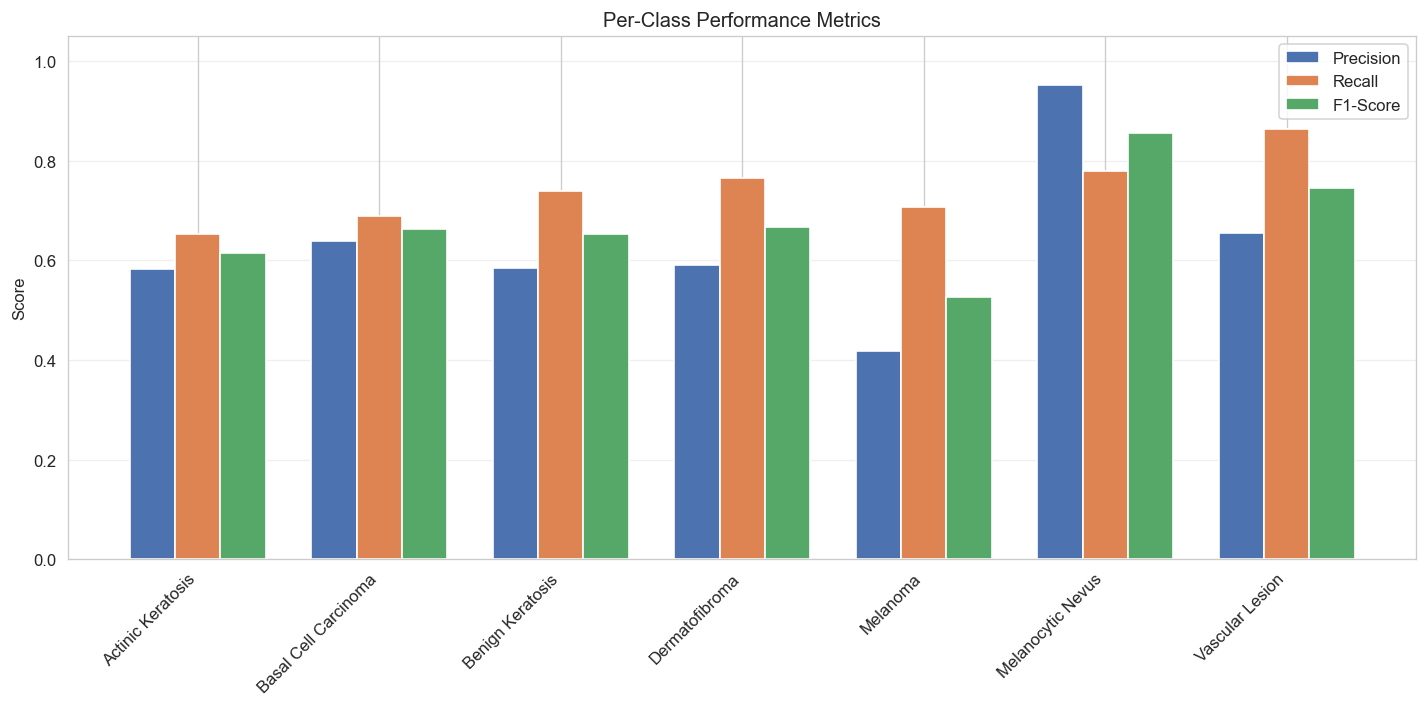

               Class Short  Precision   Recall  F1-Score  Support
   Actinic Keratosis akiec   0.581818 0.653061  0.615385       49
Basal Cell Carcinoma   bcc   0.638554 0.688312  0.662500       77
    Benign Keratosis   bkl   0.583732 0.739394  0.652406      165
      Dermatofibroma    df   0.590909 0.764706  0.666667       17
            Melanoma   mel   0.418440 0.706587  0.525612      167
   Melanocytic Nevus    nv   0.951397 0.778330  0.856206     1006
     Vascular Lesion  vasc   0.655172 0.863636  0.745098       22


In [7]:
from sklearn.metrics import precision_score, recall_score, f1_score

# Compute per-class metrics
precisions = precision_score(y_true, y_pred, average=None, zero_division=0)
recalls = recall_score(y_true, y_pred, average=None, zero_division=0)
f1s = f1_score(y_true, y_pred, average=None, zero_division=0)

# Create a DataFrame for easy viewing
metrics_df = pd.DataFrame({
    'Class': [CLASS_LABELS[c] for c in CLASS_NAMES],
    'Short': CLASS_NAMES,
    'Precision': precisions,
    'Recall': recalls,
    'F1-Score': f1s,
    'Support': [(y_true == i).sum() for i in range(NUM_CLASSES)],
})

# Plot
fig, ax = plt.subplots(figsize=(12, 6))

x = np.arange(len(CLASS_NAMES))
width = 0.25

bars1 = ax.bar(x - width, precisions, width, label='Precision', color='#4C72B0')
bars2 = ax.bar(x, recalls, width, label='Recall', color='#DD8452')
bars3 = ax.bar(x + width, f1s, width, label='F1-Score', color='#55A868')

ax.set_ylabel('Score')
ax.set_title('Per-Class Performance Metrics')
ax.set_xticks(x)
ax.set_xticklabels([CLASS_LABELS[c] for c in CLASS_NAMES], rotation=45, ha='right')
ax.legend()
ax.set_ylim(0, 1.05)
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
fig.savefig(RESULTS_DIR / 'per_class_metrics.png', dpi=150, bbox_inches='tight')
plt.show()

print(metrics_df.to_string(index=False))

---
## 5. Misclassified Examples

The most confident wrong predictions — are the mistakes reasonable or obvious errors?

Total misclassified: 363 / 1503 (24.2%)



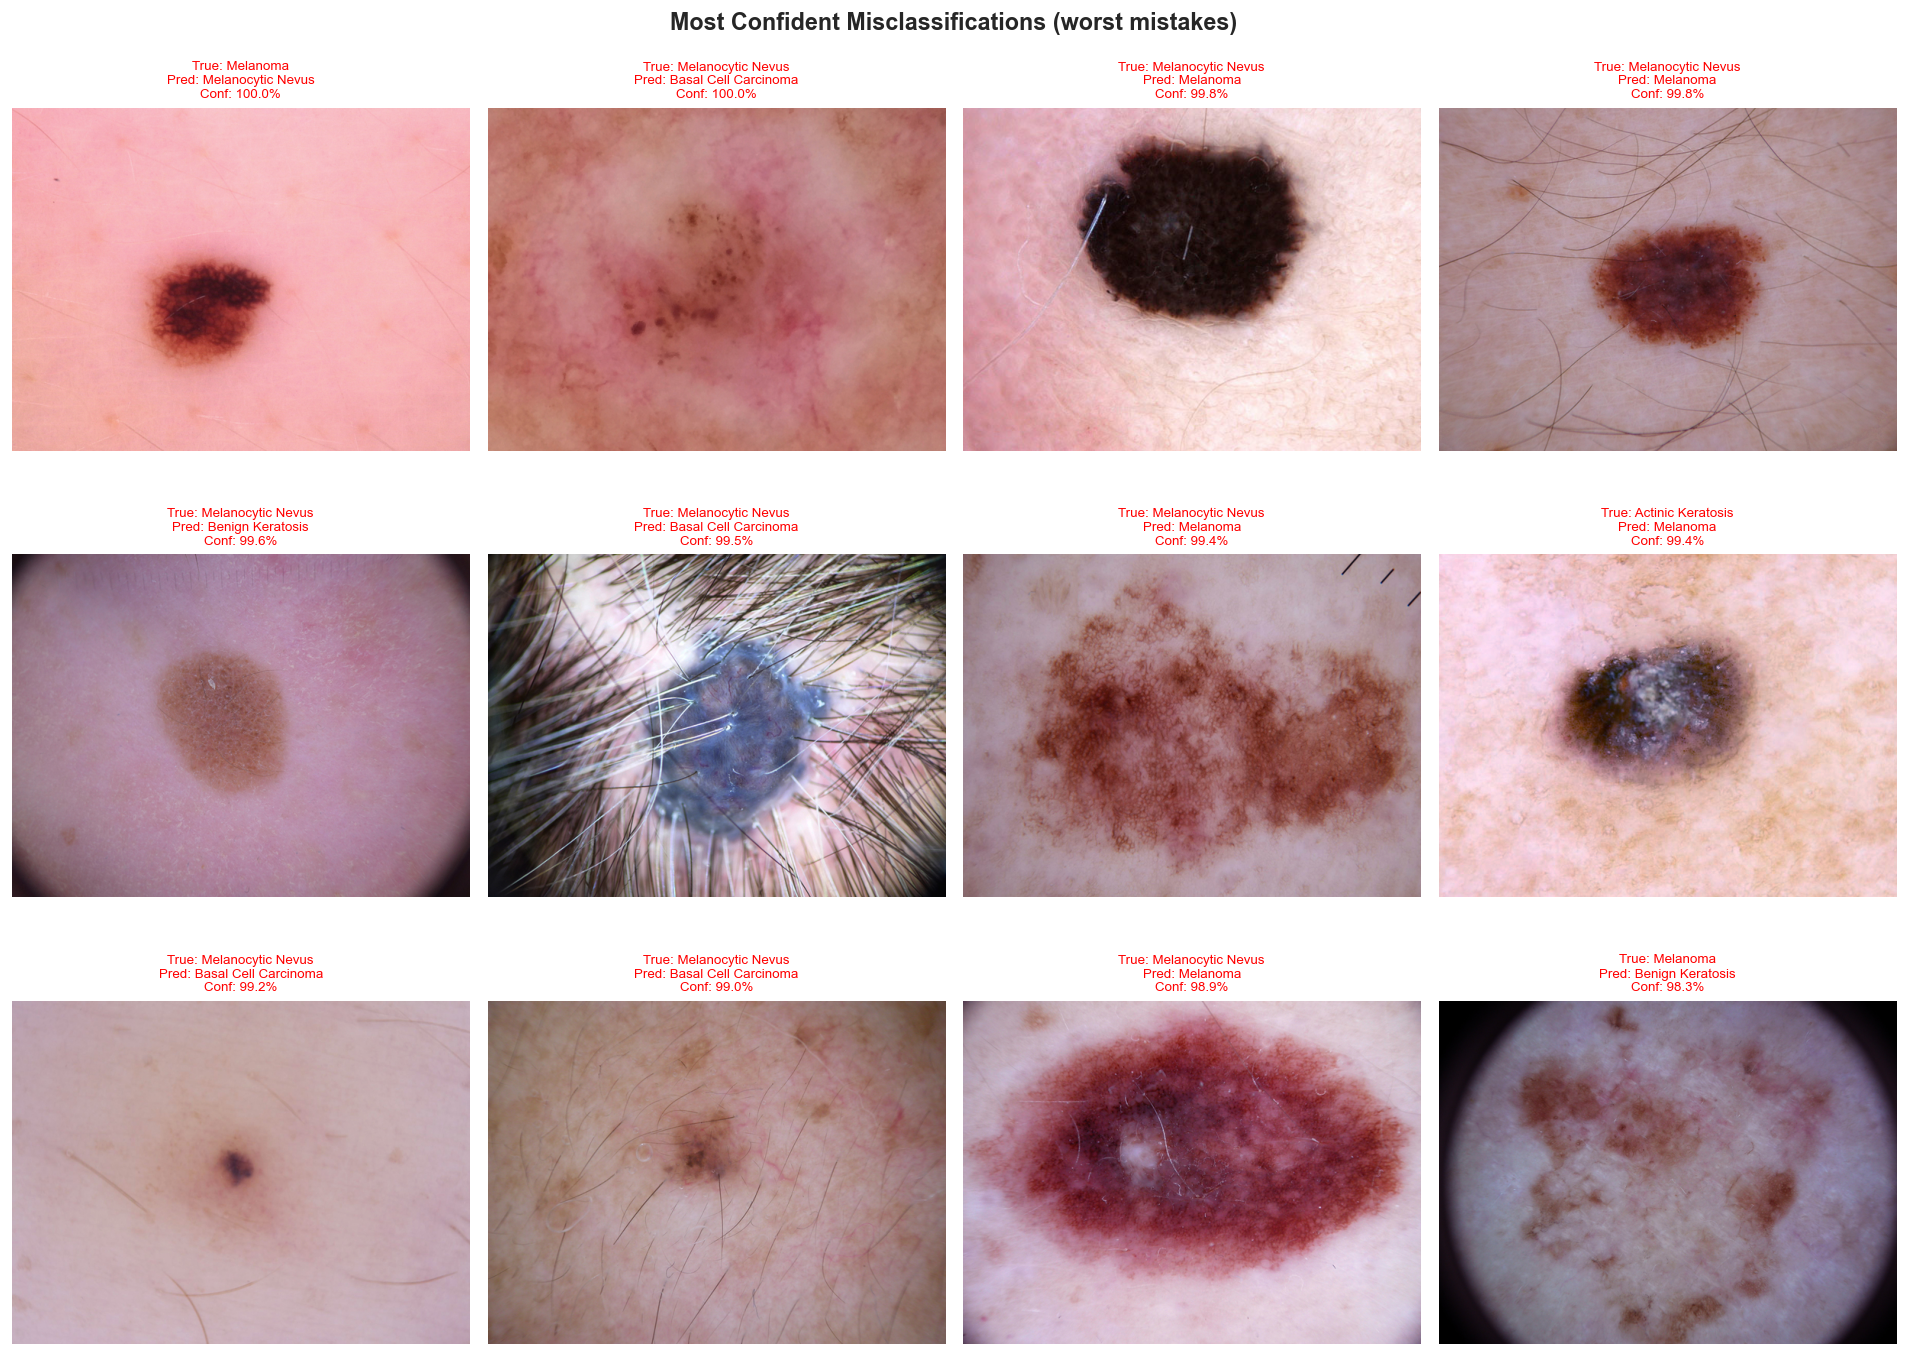

In [8]:
# Find misclassified samples
test_df_reset = test_df.reset_index(drop=True)
misclassified_idx = np.where(y_true != y_pred)[0]

print(f'Total misclassified: {len(misclassified_idx)} / {len(y_true)} ({len(misclassified_idx)/len(y_true)*100:.1f}%)')
print()

# Build image path lookup
image_path_map = {}
for d in image_dirs:
    if d.exists():
        for f in d.iterdir():
            if f.suffix == '.jpg':
                image_path_map[f.stem] = f

# Sort by confidence (highest confidence mistakes are most interesting)
misclassified_conf = confidences[misclassified_idx]
sorted_idx = misclassified_idx[np.argsort(-misclassified_conf)]  # Highest confidence first

# Show top 12 most confident mistakes
n_show = min(12, len(sorted_idx))
fig, axes = plt.subplots(3, 4, figsize=(16, 12))

for i, idx in enumerate(sorted_idx[:n_show]):
    row = test_df_reset.iloc[idx]
    img_path = image_path_map.get(row['image_id'])
    
    ax = axes[i // 4, i % 4]
    
    if img_path and img_path.exists():
        img = Image.open(img_path)
        ax.imshow(img)
    
    true_label = CLASS_LABELS[CLASS_NAMES[y_true[idx]]]
    pred_label = CLASS_LABELS[CLASS_NAMES[y_pred[idx]]]
    conf = confidences[idx]
    
    ax.set_title(f'True: {true_label}\nPred: {pred_label}\nConf: {conf:.1%}', 
                 fontsize=8, color='red')
    ax.axis('off')

plt.suptitle('Most Confident Misclassifications (worst mistakes)', fontsize=14, fontweight='bold')
plt.tight_layout()
fig.savefig(RESULTS_DIR / 'misclassified_examples.png', dpi=150, bbox_inches='tight')
plt.show()

### Error Analysis

Most misclassified images are genuinely ambiguous — visually similar classes (mel↔nv, akiec↔bkl). The model struggles with the same cases that challenge dermatologists.

---
## 6. Top Error Pairs

In [9]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_true, y_pred)

# Find the biggest off-diagonal values (most common mistakes)
errors = []
for i in range(NUM_CLASSES):
    for j in range(NUM_CLASSES):
        if i != j and cm[i, j] > 0:
            errors.append({
                'true': CLASS_LABELS[CLASS_NAMES[i]],
                'predicted': CLASS_LABELS[CLASS_NAMES[j]],
                'count': cm[i, j],
                'pct_of_true': cm[i, j] / cm[i].sum() * 100
            })

errors_df = pd.DataFrame(errors).sort_values('count', ascending=False).head(10)
print('Top 10 Most Common Misclassifications:')
print('=' * 70)
for _, row in errors_df.iterrows():
    print(f'  {row["true"]:30s} -> {row["predicted"]:30s}  ({int(row["count"]):3d} cases, {row["pct_of_true"]:.1f}% of actual)')

print(f'\nTotal errors: {(y_true != y_pred).sum()}')

Top 10 Most Common Misclassifications:
  Melanocytic Nevus              -> Melanoma                        (130 cases, 12.9% of actual)
  Melanocytic Nevus              -> Benign Keratosis                ( 58 cases, 5.8% of actual)
  Melanoma                       -> Melanocytic Nevus               ( 22 cases, 13.2% of actual)
  Melanocytic Nevus              -> Basal Cell Carcinoma            ( 20 cases, 2.0% of actual)
  Benign Keratosis               -> Melanoma                        ( 17 cases, 10.3% of actual)
  Benign Keratosis               -> Melanocytic Nevus               ( 17 cases, 10.3% of actual)
  Melanoma                       -> Benign Keratosis                ( 16 cases, 9.6% of actual)
  Actinic Keratosis              -> Melanoma                        ( 10 cases, 20.4% of actual)
  Basal Cell Carcinoma           -> Actinic Keratosis               ( 10 cases, 13.0% of actual)
  Basal Cell Carcinoma           -> Benign Keratosis                (  8 cases, 10.4% of ac

### Error Patterns

- **nv → mel** (mole predicted as melanoma) — false alarm, but safer than missing a real melanoma
- **mel → nv** (melanoma predicted as mole) — the dangerous mistake, melanomas can look like regular moles
- Most errors are between visually similar classes, not random

---
## Summary

| Analysis | Result |
|----------|--------|
| **Mean AUC** | 0.957 — excellent class separation |
| **Confidence** | Higher when correct — well-calibrated |
| **Main errors** | mel↔nv, akiec↔bkl — visually similar classes |

**Next** -> `04_gradcam.ipynb` (see WHERE the model looks)